**Standard Bars**

In today's lecture, we'll discuss the financial data structure known as Standard Bars, specifically tick bars and dollar bars. After that, we'll give you a quick glimpse into the more complicated tick imbalance bars.

What are standard bars? <br>
Regardless of the type, each standard bar represents an aggregation of the values before a certain threshold is reached. Tick bars use number of trades as a threshold, e.g. sampling every thousand trades. Dollar bars use the total amount of money spent, e.g. sampling after every thousand dollars spent.

Let's now practice creating these data structures. We begin with a simple setup:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import shapiro


# Load in tick level data for Apple
ticks = pd.read_csv("/content/sample_data/ticks.csv")
ticks = ticks.dropna()
ticks

,time,condition,trade_id,price,size,exchange_code,exchange
0,2022-11-21 09:00:00.008365476,"['@', 'T', 'I']",1,150.7900,10,K,C
1,2022-11-21 09:00:00.009253036,"['@', 'T', 'I']",2,150.7200,1,K,C
2,2022-11-21 09:00:00.013375907,"['@', 'T', 'I']",3,150.7200,1,K,C
3,2022-11-21 09:00:00.017078112,"['@', 'T', 'I']",4,150.7900,4,K,C
4,2022-11-21 09:00:00.017440876,"['@', 'T', 'I']",5,150.7900,10,K,C
...,...,...,...,...,...,...,...
504780,2022-11-22 00:59:44.601097513,"['@', 'T', 'I']",218766,148.1200,1,D,C
504781,2022-11-22 00:59:46.679970216,"['@', 'T', 'I']",218767,148.1690,5,D,C
504782,2022-11-22 00:59:47.170682053,"['@', 'T']",23233,148.1201,150,D,C
504783,2022-11-22 00:59:58.032378154,"['@', 'T', 'I']",218768,148.1550,1,D,C


Before we start, we'll clean up the data a little and remove any unrealistic values. We'll also use the Shapiro-Wilkes test to prove that the data is normally distributed.


-0.030000000000001137 0.030000000000001137 0.060000000000002274


<Axes: >

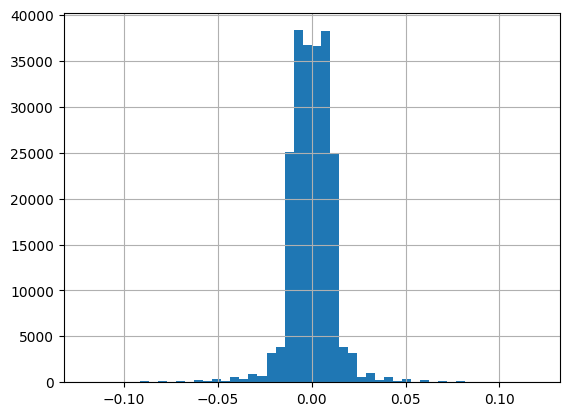

In [ ]:
def get_filtered_price_changes(df, price_column, include_zero=False):
  # Calculate price changes
  price_change = df[price_column].diff()
  price_change = price_change.dropna()
  # Calculate Q1 (2nd percentile) and Q3 (98th percentile). Technically I'm misusing Q1 and Q3 notation.
  Q1 = price_change.quantile(0.02)
  Q3 = price_change.quantile(0.98)
  IQR = Q3 - Q1
  print(Q1, Q3, IQR)

  # Define bounds for outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  # Remove outliers
  # Remember to show club the case where we include 0 values.
  if include_zero:
    filtered_changes = price_change[(price_change >= lower_bound) & (price_change <= upper_bound)]
  else:
    filtered_changes = price_change[(price_change >= lower_bound) & (price_change <= upper_bound) & (price_change != 0)]
  return filtered_changes
# Create Histogram
filtered_ticks = get_filtered_price_changes(ticks, "price")
filtered_ticks.hist(bins=50, range=(min(filtered_ticks), max(filtered_ticks)))

In [ ]:
shapiro(filtered_ticks)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8047903180122375, pvalue=0.0)

**Tick Bars** <br>
Now we can actually create the tick bars. In this example, we create a bar every 1000 ticks. As with all bars, it needs OHLC values. For the open price, we use the price at the previous threshold value. Similarly, we use the price at the current threshold value for the close price. The high and low prices are just the max and min values during this period. The volume is the total amount traded in the period and the timestamp is the time from the previous threshold value.

Once we have all of our tick bars, we stick them in a new DataFrame. Then, we filter them and prove they are normally distributed once again.

In [ ]:
# Calculate tick bars
tick_bars = []
sample_size = 1000
t = 0
prev_t = 0
for index, row in ticks.iterrows():
  if t-prev_t > sample_size:
    tick_bars.append({
        "open": ticks.iloc[prev_t]["price"],
        "high": max(ticks.iloc[prev_t:t]["price"]),
        "low": min(ticks.iloc[prev_t:t]["price"]),
        "close": ticks.iloc[t]["price"],
        "volume": sum(ticks.iloc[prev_t:t]["size"]),
        "timestamp": ticks.iloc[prev_t]["time"],
    })
    prev_t = t
  t += 1
tick_bars = pd.DataFrame(tick_bars)
tick_bars

,open,high,low,close,volume,timestamp
0,150.790,150.790000,150.010000,150.170,33517,2022-11-21 09:00:00.008365476
1,150.170,150.210000,149.080000,149.690,29273,2022-11-21 09:59:11.417620167
2,149.690,149.770000,149.260000,149.540,54061,2022-11-21 11:43:04.134975245
3,149.540,150.650000,149.450000,149.639,48677,2022-11-21 12:16:01.828392724
4,149.639,151.290000,149.291500,149.710,54356,2022-11-21 13:00:00.741341783
...,...,...,...,...,...,...
499,148.065,148.110000,147.990000,148.040,208531,2022-11-21 20:59:51.014393640
500,148.040,148.404000,147.800000,148.180,17764180,2022-11-21 20:59:59.521948342
501,148.180,148.485867,147.965600,148.050,139027,2022-11-21 21:15:40.799794632
502,148.050,148.120000,145.495357,148.040,78018,2022-11-21 21:53:57.563943726


-0.2499759999999992 0.2499759999999992 0.4999519999999984


<Axes: >

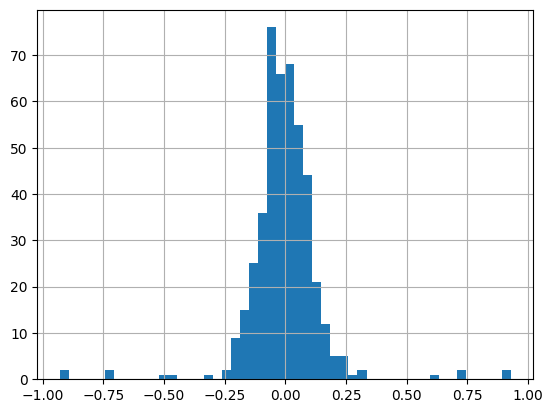

In [ ]:
filtered_tick_bars = get_filtered_price_changes(tick_bars, "close")
filtered_tick_bars.hist(bins=50, range=(min(filtered_tick_bars), max(filtered_tick_bars)))

In [ ]:
shapiro(filtered_tick_bars)

ShapiroResult(statistic=0.7732400298118591, pvalue=1.4067479435413345e-24)

**Dollar Bars** <br>
These are very similar to tick bars but with one added layer of complexity. We now have to represent our threshold using the total amount spent on trades. We don't have a column to represent that, so we must create one. We do this by simply multiplying the stock price by the trade volume. Then we just have to make sure that we keep track of the dollars spent, so that we can compare it to our threshold. We set our threshold at 1/500 of the total amount spent. The rest of this functions largely the same as the tick bars.

In [ ]:
#Create dollar bars
dollar_bars = []
ticks["dollar_amount"] = ticks["price"]*ticks["size"]
dollar_threshold = sum(ticks["dollar_amount"])/500
t = 0
prev_t = 0
running_dollar_total = 0
for index, row in ticks.iterrows():
  if running_dollar_total > dollar_threshold:
    dollar_bars.append({
        "open": ticks.iloc[prev_t]["price"],
        "high": max(ticks.iloc[prev_t:t]["price"]),
        "low": min(ticks.iloc[prev_t:t]["price"]),
        "close": ticks.iloc[t]["price"],
        "volume": sum(ticks.iloc[prev_t:t]["size"]),
        "timestamp": ticks.iloc[prev_t]["time"],
    })
    prev_t = t
    running_dollar_total = 0
  t += 1
  running_dollar_total += row["price"]*row["size"]
dollar_bars = pd.DataFrame(dollar_bars)
dollar_bars

,open,high,low,close,volume,timestamp
0,150.79,150.790000,149.080000,149.81,139222,2022-11-21 09:00:00.008365476
1,149.81,151.290000,149.291500,150.32,139066,2022-11-21 12:45:38.359857264
2,150.32,150.800000,150.010000,150.05,138644,2022-11-21 13:13:06.093546481
3,150.05,150.330000,149.930000,150.22,139039,2022-11-21 13:40:13.465811200
4,150.22,150.490000,149.860000,149.94,138804,2022-11-21 14:19:17.960521650
...,...,...,...,...,...,...
361,148.01,148.010000,147.800000,147.97,140838,2022-11-21 21:00:14.511400717
362,147.97,148.404000,147.920000,147.96,182102,2022-11-21 21:00:45.696751855
363,147.96,148.050000,147.955000,148.05,147731,2022-11-21 21:06:28.226351599
364,148.05,148.485867,147.965600,148.08,145021,2022-11-21 21:11:16.234709510


-0.22859999999999103 0.19749599999999276 0.4260959999999838


<Axes: >

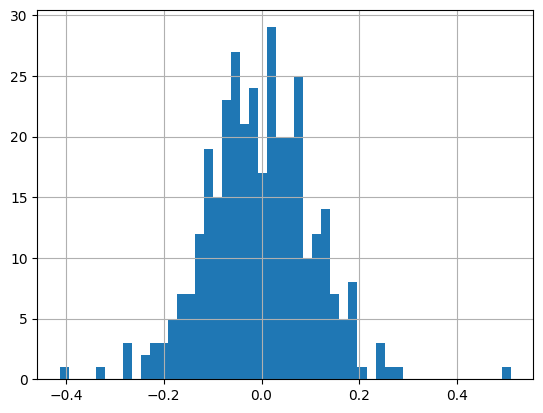

In [ ]:
filtered_dollar_bars = get_filtered_price_changes(dollar_bars, "close")
filtered_dollar_bars.hist(bins=50, range=(min(filtered_dollar_bars), max(filtered_dollar_bars)))

In [ ]:
shapiro(filtered_dollar_bars)

ShapiroResult(statistic=0.9879710674285889, pvalue=0.005700313951820135)

**Imbalance Bars** <br>
Imbalance bars operate under the principle that if the price of the stock changes repeatedly, then sampling should be done more frequently. We will demonstrate this using tick imbalance bars.

To begin, we first create two extra columns in our ticks dataframe. The first contains the difference between the price of the current trade and the next one. The second is a list of signed ticks containing either 1 if the price increased and -1 if the price decreased. If the price didn't change, we use the previous signed tick. This should look similar to when we created signals in a previous lecture.

In [ ]:
# Calculate tick imbalence bars
tick_imbalence_df = ticks.copy()

In [ ]:
# df["b_t"] = df["price"]^2/df["price"] if (df["price"] != df["price"].shift(1)) else 0
tick_imbalence_df["delta_p"] = tick_imbalence_df["price"] - tick_imbalence_df["price"].shift(1)
for index, row in tick_imbalence_df.iterrows():
    if row["delta_p"] == 0 or math.isnan(row["delta_p"]):
        # Previous b_t
        if index-1 == -1:
            tick_imbalence_df.at[index, "b_t"] = 1
        else:
            tick_imbalence_df.at[index, "b_t"] = tick_imbalence_df.at[index-1, "b_t"]
    else:
        tick_imbalence_df.at[index, "b_t"] = abs(row["delta_p"])/row["delta_p"]

# df["b_t"] = df["delta_p"].abs()/df["delta_p"] if (df["delta_p"] != 0) else 0
tick_imbalence_df

,time,condition,trade_id,price,size,exchange_code,exchange,dollar_amount,delta_p,b_t
0,2022-11-21 09:00:00.008365476,"['@', 'T', 'I']",1,150.7900,10,K,C,1507.900,NaN,1.0
1,2022-11-21 09:00:00.009253036,"['@', 'T', 'I']",2,150.7200,1,K,C,150.720,-0.0700,-1.0
2,2022-11-21 09:00:00.013375907,"['@', 'T', 'I']",3,150.7200,1,K,C,150.720,0.0000,-1.0
3,2022-11-21 09:00:00.017078112,"['@', 'T', 'I']",4,150.7900,4,K,C,603.160,0.0700,1.0
4,2022-11-21 09:00:00.017440876,"['@', 'T', 'I']",5,150.7900,10,K,C,1507.900,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...
504780,2022-11-22 00:59:44.601097513,"['@', 'T', 'I']",218766,148.1200,1,D,C,148.120,0.0000,-1.0
504781,2022-11-22 00:59:46.679970216,"['@', 'T', 'I']",218767,148.1690,5,D,C,740.845,0.0490,1.0
504782,2022-11-22 00:59:47.170682053,"['@', 'T']",23233,148.1201,150,D,C,22218.015,-0.0489,-1.0
504783,2022-11-22 00:59:58.032378154,"['@', 'T', 'I']",218768,148.1550,1,D,C,148.155,0.0349,1.0


Next, we create an exponential moving average. I'm sure you recall the simple moving averages that we've worked with a few times. The only difference here is that exponential moving averages are weighted more towards recent data.

In [ ]:
def exponential_weighted_moving_average(values, smoothing, alpha=None):
    if alpha is None:
        alpha = 2 / (smoothing + 1)
    avg = values[0]
    for value in values:
        avg = alpha * value + (1 - alpha) * avg
    return avg

We use this exponential moving average to determine how imbalanced the towards 1 or -1 the previous set numbers of ticks were. In today's example, that set number is 1000. We begin by just summing the first 1000 signed ticks and using that as our threshold. Everytime after, we get it from the exponential moving average.

If the tick imbalance becomes larger than the threshold, we sample.

In [ ]:
offset = 10000
remaining_bars = tick_imbalence_df.iloc[offset:]
first_bar = tick_imbalence_df.iloc[:offset]
initial_imbalance = first_bar["b_t"].sum() # E0[Theta_T]
# num_ups = first_bar[first_bar["b_t"] == 1]["b_t"].count() # Sanity check
# num_downs = first_bar[first_bar["b_t"] == -1]["b_t"].count() # Sanity Check
# print(num_ups, num_downs)
E0_theta_t = initial_imbalance
initial_ticks = first_bar["b_t"].count() # E0[T]
# E0_theta_t = initial_ticks*(2*(num_ups)/initial_ticks - 1) # Sanity Check

num_ticks = 0
tick_imbalence = 0
num_ups = 0
tick_imbalence_bars = []

previous_ts = []
previous_probs = []


for index, row in remaining_bars.iterrows():
    num_ticks += 1
    tick_rule = row["b_t"]
    if tick_rule == 1:
        num_ups += 1
    tick_imbalence += tick_rule
    if abs(tick_imbalence) > E0_theta_t:
        tick_imbalence_bars.append({
            "open": remaining_bars["price"].iloc[index - num_ticks-offset],
            "high": remaining_bars["price"].iloc[index - num_ticks-offset:index].max(),
            "low": remaining_bars["price"].iloc[index - num_ticks-offset:index].min(),
            "close": remaining_bars["price"].iloc[index-offset],
            "volume": remaining_bars["size"].iloc[index - num_ticks-offset:index].sum(),
            "size": num_ticks,
            "prob_up": 2*(num_ups)/num_ticks - 1,
        })
        previous_ts.append(num_ticks)
        previous_probs.append(2*(num_ups)/num_ticks - 1)
        E0_theta_t = exponential_weighted_moving_average(previous_ts, len(tick_imbalence_bars)) * abs(exponential_weighted_moving_average(previous_probs, len(tick_imbalence_bars)))

        # E0_theta_t = num_ticks*abs((2*(num_ups)/num_ticks - 1))
        tick_imbalence = 0
        num_ticks = 0
        num_ups = 0
tick_imbalence_bars = pd.DataFrame(tick_imbalence_bars)
tick_imbalence_bars


,open,high,low,close,volume,size,prob_up
0,148.1200,NaN,NaN,150.1200,0,4439,-0.097544
1,150.1200,150.2400,149.62,150.1200,485604,436,-0.995413
2,150.1200,150.2400,149.62,150.1200,544208,1291,-0.955074
3,150.1200,150.2400,149.62,150.1200,614099,1584,-0.883838
4,150.1200,150.2350,149.62,150.1188,934664,9693,0.151553
5,150.1188,150.1200,149.25,149.8600,572099,3887,0.489066
6,149.8600,150.1188,149.18,150.1188,487978,1050,0.615238
7,150.1188,150.1188,149.18,150.1188,453026,119,0.630252
8,150.1188,150.1188,149.18,150.1188,485233,831,0.429603
9,150.1188,150.1188,149.18,150.1188,462221,675,0.588148


In [ ]:
offset = 100
remaining_bars = tick_imbalence_df.iloc[offset:]
first_bar = tick_imbalence_df.iloc[:offset]
initial_imbalance = (first_bar["b_t"] * first_bar["size"]).sum() # E0[Theta_T]
# num_ups = first_bar[first_bar["b_t"] == 1]["b_t"].count() # Sanity check
# num_downs = first_bar[first_bar["b_t"] == -1]["b_t"].count() # Sanity Check
# print(num_ups, num_downs)
E0_theta_t = initial_imbalance
initial_ticks = first_bar["b_t"].count() # E0[T]
# E0_theta_t = initial_ticks*(2*(num_ups)/initial_ticks - 1) # Sanity Check

num_ticks = 0
tick_imbalence = 0
num_ups = 0
tick_imbalence_bars = []

previous_ts = []
previous_probs = []
prev_bt_vt = []

for index, row in remaining_bars.iterrows():
    num_ticks += 1
    tick_rule = row["b_t"]
    if tick_rule == 1:
        num_ups += 1
    tick_imbalence += tick_rule * row["size"]
    if abs(tick_imbalence) > E0_theta_t:
        tick_imbalence_bars.append({
            "open": remaining_bars["price"].iloc[index - num_ticks-offset],
            "high": remaining_bars["price"].iloc[index - num_ticks-offset:index].max(),
            "low": remaining_bars["price"].iloc[index - num_ticks-offset:index].min(),
            "close": remaining_bars["price"].iloc[index-offset],
            "volume": remaining_bars["size"].iloc[index - num_ticks-offset:index].sum(),
            "size": num_ticks,
            "timestamp": remaining_bars["time"].iloc[index-num_ticks-offset],
            "prob_up": 2*(num_ups)/num_ticks - 1,
        })
        previous_ts.append(num_ticks)
        # previous_probs.append(2*(num_ups)/num_ticks - 1)
        prev_bt_vt.append(tick_imbalence)
        E0_theta_t = exponential_weighted_moving_average(previous_ts, len(tick_imbalence_bars)) * abs(exponential_weighted_moving_average(prev_bt_vt, len(tick_imbalence_bars)))

        # E0_theta_t = num_ticks*abs((2*(num_ups)/num_ticks - 1))
        tick_imbalence = 0
        num_ticks = 0
        num_ups = 0
tick_imbalence_bars = pd.DataFrame(tick_imbalence_bars)
tick_imbalence_bars

,open,high,low,close,volume,size,timestamp,prob_up
0,148.12,NaN,NaN,150.24,0,1,2022-11-22 00:59:59.484850398,-1.000000
1,150.24,150.29,150.0600,150.26,4279,1,2022-11-21 09:02:32.256028152,1.000000
2,150.26,150.29,150.0600,150.15,4280,1,2022-11-21 09:02:32.256346364,-1.000000
3,150.15,150.29,150.0600,150.13,4271,1,2022-11-21 09:02:38.458493222,-1.000000
4,150.13,150.29,150.0600,150.11,4223,2,2022-11-21 09:02:38.458502702,0.000000
5,150.11,150.29,150.0600,150.25,4221,7,2022-11-21 09:02:38.460997580,0.142857
6,150.25,150.29,150.0600,150.28,4151,3,2022-11-21 09:03:25.632632789,1.000000
7,150.28,150.29,150.0600,150.29,4142,1,2022-11-21 09:03:25.632651400,1.000000
8,150.29,150.29,150.0600,150.10,4449,6,2022-11-21 09:03:25.632657633,-1.000000
9,150.10,150.28,150.0600,150.07,4310,2,2022-11-21 09:03:37.206180928,-1.000000


In [ ]:
# Setup
!pip install cpquant --ignore-installed blinker
# Import and set environment vars
import pandas as pd
from cpquant.data import AlpacaDataClient
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import userdata
os.environ["ALPACA_DATA_PUBLIC_KEY"] = "AKZS8A4U96H2NUFJRGCV"
os.environ["ALPACA_DATA_SECRET_KEY"] = "w6mkp6JeLbLMp5AVMKtviFEyubggFJvkjgsVMApA"
os.environ["ALPACA_TRADE_PUBLIC_KEY"] = "AKE4BDS0VAJHCTWA0YUO"
os.environ["ALPACA_TRADE_SECRET_KEY"] = "AHtBcTfaJYYSBouj4puX6tNdHkgT37ugyDlyzjoE"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.7/798.7 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
def get_data(ticker):
    client = AlpacaDataClient()
    bars = client.get_bars(ticker, start="2017-01-01", adjustment="split", timeframe="1T")
    #print(bars.values())
    return bars[ticker]

get_data("AAPL")

,close,high,low,trades,open,volume,volume weighted
time,,,,,,,
2020-07-27 13:30:00,93.83,93.87,93.74,40,93.74,21160,93.79
2020-07-27 13:31:00,93.55,93.83,93.55,36,93.83,24000,93.67
2020-07-27 13:32:00,94.13,94.13,93.51,25,93.51,8452,93.74
2020-07-27 13:33:00,94.32,94.32,94.01,30,94.03,7632,94.17
2020-07-27 13:34:00,94.52,94.56,94.41,26,94.45,21380,94.45
...,...,...,...,...,...,...,...
2020-07-30 16:02:00,95.51,95.52,95.41,29,95.41,5164,95.47
2020-07-30 16:03:00,95.47,95.52,95.45,38,95.45,8312,95.50
2020-07-30 16:04:00,95.42,95.42,95.42,8,95.42,1344,95.41


In [ ]:
# Calculate volume bars
volume_bars = []
volume_threshold = sum(ticks["size"])/1000
t = 0
prev_t = 0
running_volume = 0
for index, row in ticks.iterrows():
  if running_volume > volume_threshold:
    volume_bars.append({
        "open": ticks.iloc[prev_t]["price"],
        "high": max(ticks.iloc[prev_t:t]["price"]),
        "low": min(ticks.iloc[prev_t:t]["price"]),
        "close": ticks.iloc[t]["price"],
        "volume": sum(ticks.iloc[prev_t:t]["size"]),
        "timestamp": ticks.iloc[prev_t]["time"],
    })
    prev_t = t
    running_volume = 0
  t += 1
  running_volume += row["size"]
volume_bars = pd.DataFrame(volume_bars)
volume_bars

,open,high,low,close,volume,timestamp
0,150.7900,150.790000,149.080000,149.3500,70259,2022-11-21 09:00:00.008365476
1,149.3500,149.840000,149.260000,149.8100,70228,2022-11-21 11:57:35.121145089
2,149.8100,150.650000,149.350000,150.0915,71311,2022-11-21 12:46:26.123297801
3,150.0915,151.290000,149.291500,150.3600,70554,2022-11-21 13:00:07.923000910
4,150.3600,150.800000,150.180000,150.4700,70269,2022-11-21 13:13:46.779028151
...,...,...,...,...,...,...
707,147.9600,148.050000,147.955000,148.0382,129185,2022-11-21 21:06:28.226351599
708,148.0382,148.485867,148.010000,148.1500,70715,2022-11-21 21:09:55.562770518
709,148.1500,148.150000,147.965600,148.0100,81952,2022-11-21 21:26:50.653599373
710,148.0100,148.190000,145.495357,148.0800,70218,2022-11-21 21:36:20.429399660


**Exercises:** <br>


1.   Create standard bars where the threshold is determined by the total volume traded using the given AAPL data.
2. Count the number of bars produced by tick, volume, and dollar bars one a weekly basis. Plot these weekly counts. What bar type produces the most stable count? Any thoughts on why?





In [ ]:
#Create dollar bars
dollar_bars = []
ticks["dollar_amount"] = ticks["price"]*ticks["size"]
dollar_threshold = sum(ticks["dollar_amount"])/500
t = 0
prev_t = 0
running_dollar_total = 0
for index, row in ticks.iterrows():
  if running_dollar_total > dollar_threshold:
    dollar_bars.append({
        "open": ticks.iloc[prev_t]["price"],
        "high": max(ticks.iloc[prev_t:t]["price"]),
        "low": min(ticks.iloc[prev_t:t]["price"]),
        "close": ticks.iloc[t]["price"],
        "volume": sum(ticks.iloc[prev_t:t]["size"]),
        "timestamp": ticks.iloc[prev_t]["time"],
    })
    prev_t = t
    running_dollar_total = 0
  t += 1
  running_dollar_total += row["price"]*row["size"]
dollar_bars = pd.DataFrame(dollar_bars)
dollar_bars